In [1]:
import stackstac
import pystac
import pystac_client
import numpy as np
import geopandas as gpd
from datetime import datetime
import os
from dask.distributed import Client
import dask.diagnostics
import rioxarray
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
start_time = '2019-12-01'
end_time = '2020-08-01'
time_slice = slice(start_time,end_time)
bounding_box_gf=gpd.read_file('shapefiles/grandmesa.geojson')
cloud_cover_threshold = 20

In [3]:
# GDAL environment variables for better performance
os.environ['AWS_REGION']='us-west-2'
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='EMPTY_DIR' 
os.environ['AWS_NO_SIGN_REQUEST']='YES' 

In [4]:
# Paste /proxy/localhost:8787 for cluster diagnostics
client = Client(local_directory='/tmp', processes=False)

In [5]:
lower_lon, upper_lat, upper_lon, lower_lat = bounding_box_gf.bounds.values[0]
lon = (lower_lon + upper_lon)/2
lat = (lower_lat + upper_lat)/2

In [6]:
URL = "https://earth-search.aws.element84.com/v0"
catalog = pystac_client.Client.open(URL)

In [7]:
items = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime=f"{start_time}/{end_time}"
).get_all_items()

In [8]:
#string = f'{ts_ds.rio.crs}'
#epsg_code = int(string[5:])
epsg_code=32613
stack = stackstac.stack(items, epsg=epsg_code)

In [9]:
stack

<xarray.DataArray 'stackstac-137f62037dfc26990cc5bd1bc43daf6b' (time: 100,
                                                                band: 17,
                                                                y: 11684,
                                                                x: 13135)>
dask.array<fetch_raster_window, shape=(100, 17, 11684, 13135), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * time                        (time) datetime64[ns] 2020-03-30T18:13:10 ......
    id                          (time) <U24 'S2A_12SYJ_20200330_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'visual' ... 'WVP' 'SCL'
  * x                           (x) float64 1.784e+05 1.784e+05 ... 3.098e+05
  * y                           (y) float64 4.404e+06 4.404e+06 ... 4.287e+06
    constellation               <U10 'sentinel-2'
    ...                          ...
    sentinel:grid_square        (time) <U2 'YJ' 'BD' 'YJ' ... 'YJ' 'YJ' 'BD'
    created                     (time) <U24 '2020-08-19T20:13:17.217Z' ... '2...
    sentinel:valid_cloud_cover  bool True
    data_coverage               (time) object None None 46.49 ... None None None
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    epsg                        int64 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(178430.0, 4287030.0, 309780.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 178430.00|\n| 0.00,-10.00, 4403870.00|\n| 0.0...
    resolution:  10.0

In [10]:
if np.unique(stack['proj:epsg']).size>1:
    stack = stack[stack['proj:epsg']!=stack['epsg']]

In [11]:
stack

<xarray.DataArray 'stackstac-137f62037dfc26990cc5bd1bc43daf6b' (time: 51,
                                                                band: 17,
                                                                y: 11684,
                                                                x: 13135)>
dask.array<getitem, shape=(51, 17, 11684, 13135), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * time                        (time) datetime64[ns] 2020-03-30T18:13:10 ......
    id                          (time) <U24 'S2A_12SYJ_20200330_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'visual' ... 'WVP' 'SCL'
  * x                           (x) float64 1.784e+05 1.784e+05 ... 3.098e+05
  * y                           (y) float64 4.404e+06 4.404e+06 ... 4.287e+06
    constellation               <U10 'sentinel-2'
    ...                          ...
    sentinel:grid_square        (time) <U2 'YJ' 'YJ' 'YJ' ... 'YJ' 'YJ' 'YJ'
    created                     (time) <U24 '2020-08-19T20:13:17.217Z' ... '2...
    sentinel:valid_cloud_cover  bool True
    data_coverage               (time) object None 46.49 None ... None None None
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    epsg                        int64 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(178430.0, 4287030.0, 309780.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 178430.00|\n| 0.00,-10.00, 4403870.00|\n| 0.0...
    resolution:  10.0

In [12]:
# import bounding box
bounding_box_utm_gf = bounding_box_gf.to_crs(stack.crs)
xmin, ymax, xmax, ymin = bounding_box_utm_gf.bounds.values[0]
#rainier_glaciers = rainier_glaciers.to_crs(stack.crs)

In [13]:
lowcloud = stack[stack["eo:cloud_cover"] < cloud_cover_threshold]
t = np.datetime64('2020-05-05T19:21:34.000000000')
lowcloud = lowcloud.loc[lowcloud.time !=t]
#stack.sel(time=time_slice) 298 images for the year
#lowcloud.sel(time=time_slice) 87 lowcloud days for the year

In [14]:
# could resample at the end in order to get more pixelwise values
if 'resample_freq' in locals():
    lowcloud = lowcloud.resample(time=resample_freq).median("time", keep_attrs=True)
#   resampled = lowcloud.resample(time=resample_freq).mean("time", keep_attrs=True)
else:
    lowcloud = lowcloud

In [15]:
lowcloud

<xarray.DataArray 'stackstac-137f62037dfc26990cc5bd1bc43daf6b' (time: 23,
                                                                band: 17,
                                                                y: 11684,
                                                                x: 13135)>
dask.array<getitem, shape=(23, 17, 11684, 13135), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/24)
  * time                        (time) datetime64[ns] 2020-04-06T18:03:14 ......
    id                          (time) <U24 'S2A_12SYJ_20200406_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'visual' ... 'WVP' 'SCL'
  * x                           (x) float64 1.784e+05 1.784e+05 ... 3.098e+05
  * y                           (y) float64 4.404e+06 4.404e+06 ... 4.287e+06
    constellation               <U10 'sentinel-2'
    ...                          ...
    sentinel:grid_square        (time) <U2 'YJ' 'YJ' 'YJ' ... 'YJ' 'YJ' 'YJ'
    created                     (time) <U24 '2020-09-19T01:27:25.874Z' ... '2...
    sentinel:valid_cloud_cover  bool True
    data_coverage               (time) object 46.21 None None ... None None None
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    epsg                        int64 32613
Attributes:
    spec:        RasterSpec(epsg=32613, bounds=(178430.0, 4287030.0, 309780.0...
    crs:         epsg:32613
    transform:   | 10.00, 0.00, 178430.00|\n| 0.00,-10.00, 4403870.00|\n| 0.0...
    resolution:  10.0

In [16]:
# select bands
rgb = lowcloud.sel(band=["B04","B03","B02"])

green, red, nir, swir = lowcloud.sel(band="B03"), lowcloud.sel(band="B04"), lowcloud.sel(band="B08"), lowcloud.sel(band="B11")

# NDWI is (B4-B11)/(B4+B11)
ndwi = (green-nir)/(green+nir)
# NDSI is (B3-B11)/(B3+B11) https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm
ndsi = (green-swir)/(green+swir)


# SCL classifications https://www.sentinel-hub.com/faq/how-get-s2a-scene-classification-sentinel-2/
scl = lowcloud.sel(band="SCL")
# look at preciptable water vapor? maybe something telling about melt / evaporation
wvp = lowcloud.sel(band="WVP")

In [17]:
ndsi

<xarray.DataArray 'stackstac-137f62037dfc26990cc5bd1bc43daf6b' (time: 23,
                                                                y: 11684,
                                                                x: 13135)>
dask.array<truediv, shape=(23, 11684, 13135), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * time                        (time) datetime64[ns] 2020-04-06T18:03:14 ......
    id                          (time) <U24 'S2A_12SYJ_20200406_0_L2A' ... 'S...
  * x                           (x) float64 1.784e+05 1.784e+05 ... 3.098e+05
  * y                           (y) float64 4.404e+06 4.404e+06 ... 4.287e+06
    constellation               <U10 'sentinel-2'
    view:off_nadir              int64 0
    ...                          ...
    sentinel:data_coverage      (time) float64 46.21 100.0 100.0 ... 100.0 46.28
    sentinel:grid_square        (time) <U2 'YJ' 'YJ' 'YJ' ... 'YJ' 'YJ' 'YJ'
    created                     (time) <U24 '2020-09-19T01:27:25.874Z' ... '2...
    sentinel:valid_cloud_cover  bool True
    data_coverage               (time) object 46.21 None None ... None None None
    epsg                        int64 32613

In [18]:
#scenes_rgb = rgb.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)
scenes_ndwi = ndwi.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)
scenes_ndsi = ndsi.sel(x=slice(xmin,xmax),y=slice(ymin,ymax)).sel(time=time_slice)

In [19]:
scenes_ndsi

<xarray.DataArray 'stackstac-137f62037dfc26990cc5bd1bc43daf6b' (time: 23,
                                                                y: 3540, x: 3956)>
dask.array<getitem, shape=(23, 3540, 3956), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * time                        (time) datetime64[ns] 2020-04-06T18:03:14 ......
    id                          (time) <U24 'S2A_12SYJ_20200406_0_L2A' ... 'S...
  * x                           (x) float64 2.175e+05 2.175e+05 ... 2.57e+05
  * y                           (y) float64 4.338e+06 4.338e+06 ... 4.303e+06
    constellation               <U10 'sentinel-2'
    view:off_nadir              int64 0
    ...                          ...
    sentinel:data_coverage      (time) float64 46.21 100.0 100.0 ... 100.0 46.28
    sentinel:grid_square        (time) <U2 'YJ' 'YJ' 'YJ' ... 'YJ' 'YJ' 'YJ'
    created                     (time) <U24 '2020-09-19T01:27:25.874Z' ... '2...
    sentinel:valid_cloud_cover  bool True
    data_coverage               (time) object 46.21 None None ... None None None
    epsg                        int64 32613

In [20]:
#%%time
#frames_rgb_all = scenes_rgb.compute()
#frames_rgb = frames_rgb_all.dropna('time',how='all')

In [21]:
%%time
frames_ndwi_all = scenes_ndwi.compute()
frames_ndwi = frames_ndwi_all.dropna('time',how='all')

CPU times: user 2min 4s, sys: 14 s, total: 2min 18s
Wall time: 1min 13s


In [22]:
%%time 
frames_ndsi_all = scenes_ndsi.compute()
frames_ndsi = frames_ndsi_all.dropna('time',how='all')

CPU times: user 1min 53s, sys: 10.7 s, total: 2min 4s
Wall time: 52.1 s


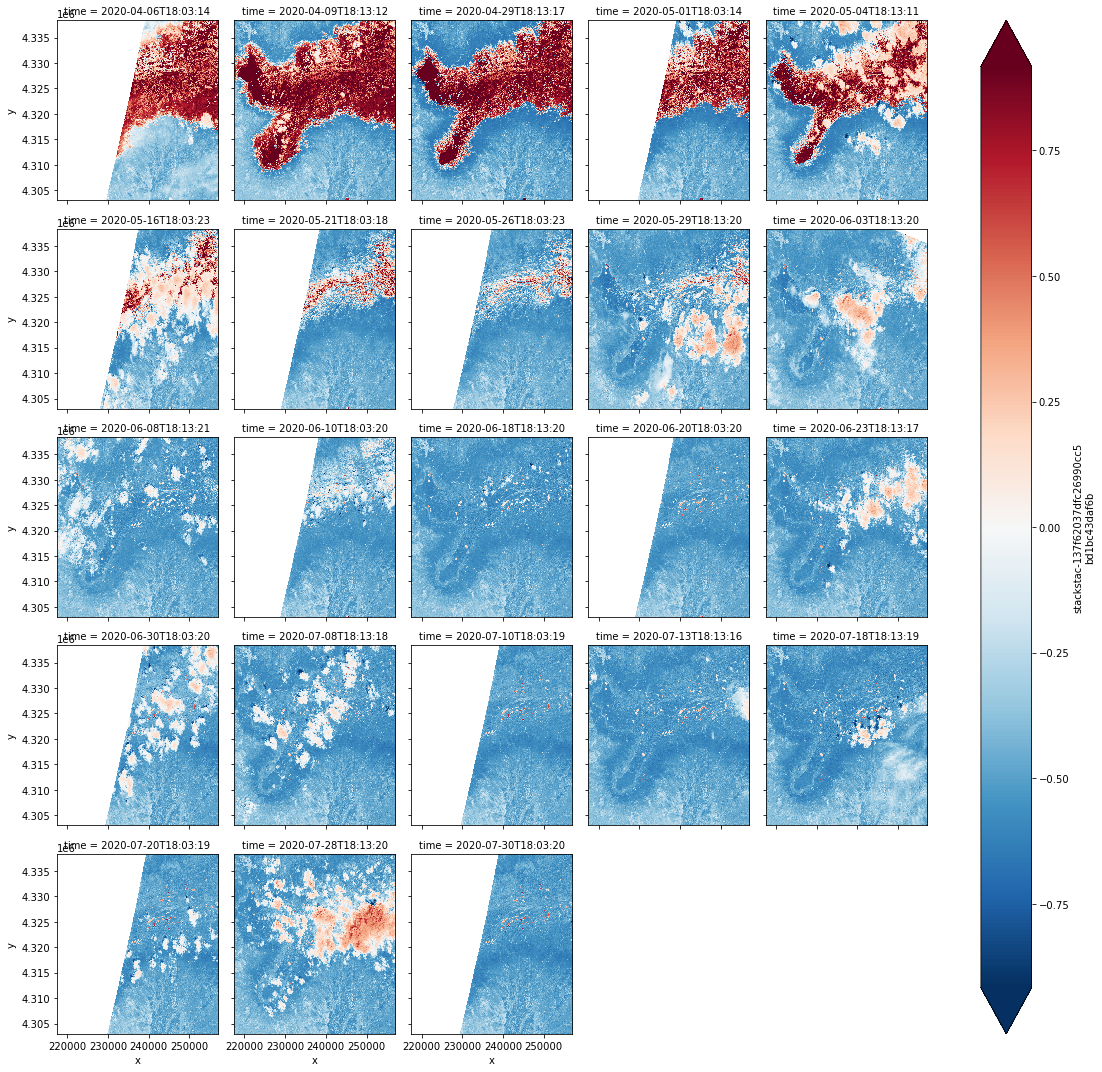

In [23]:
frames_ndsi.plot.imshow(col="time", col_wrap = 5, robust=True,aspect=1);

In [25]:
#frames_rgb.plot.imshow(col="time", col_wrap = 5, rgb='band', robust=True,aspect=1);

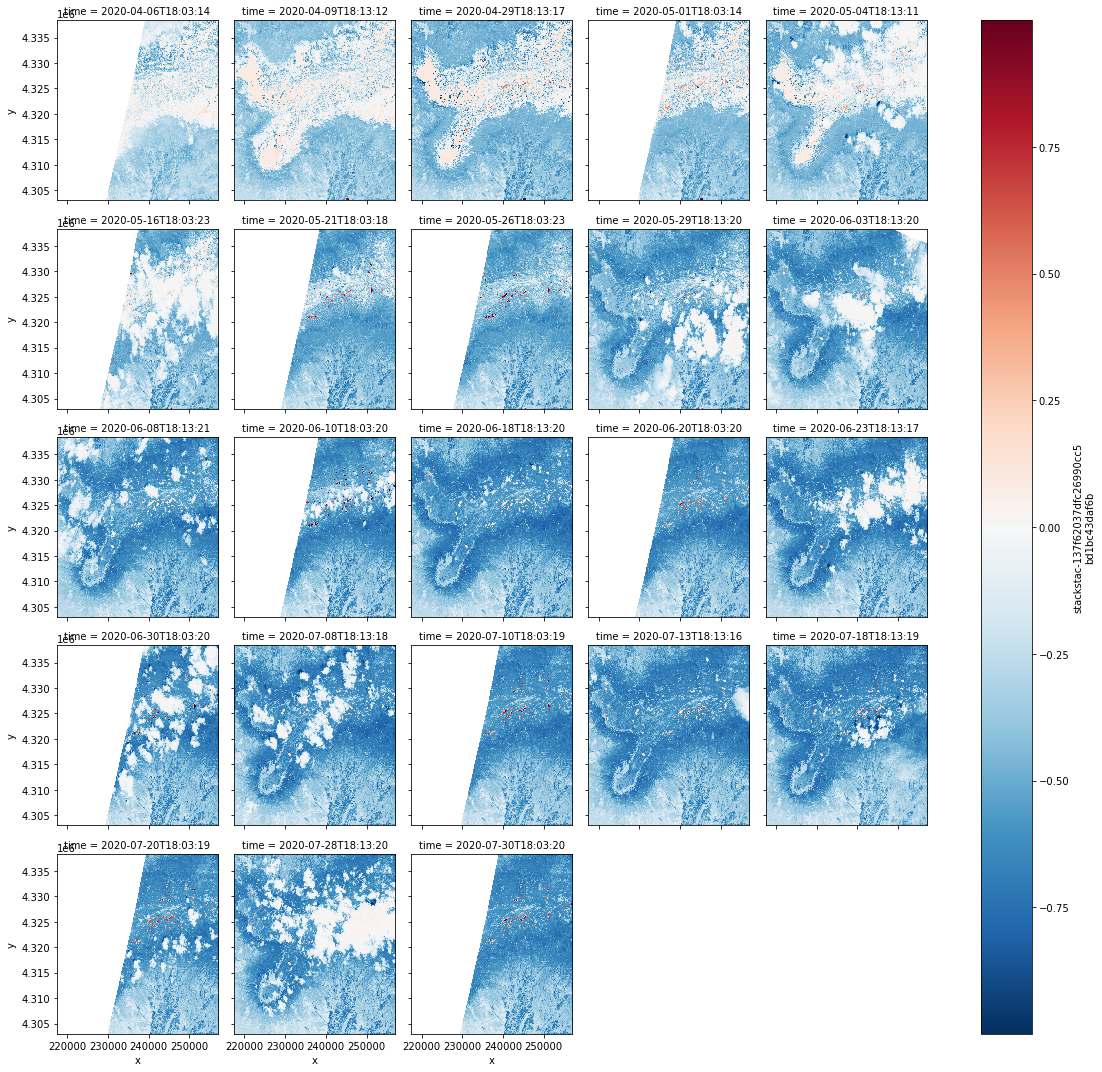

In [24]:
frames_ndwi.plot.imshow(col="time", col_wrap = 5, robust=False);

In [32]:
ndsi_pixel_count = ndsi > 0.4
ndwi_pixel_count = ndwi > 0.2

<xarray.DataArray 'stackstac-74e713eb5fd26cb73037f50afeab7726' (time: 23,
                                                                y: 11684,
                                                                x: 13135)>
dask.array<gt, shape=(23, 11684, 13135), dtype=bool, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/22)
  * time                        (time) datetime64[ns] 2020-04-06T18:03:14 ......
    id                          (time) <U24 'S2A_12SYJ_20200406_0_L2A' ... 'S...
  * x                           (x) float64 1.784e+05 1.784e+05 ... 3.098e+05
  * y                           (y) float64 4.404e+06 4.404e+06 ... 4.287e+06
    sentinel:product_id         (time) <U60 'S2A_MSIL2A_20200406T174901_N0214...
    sentinel:data_coverage      (time) float64 46.21 100.0 100.0 ... 100.0 46.28
    ...                          ...
    sentinel:valid_cloud_cover  bool True
    created                     (time) <U24 '2020-09-19T01:27:25.874Z' ... '2...
    sentinel:utm_zone           (time) int64 12 12 12 12 12 ... 12 12 12 12 12
    eo:cloud_cover              (time) float64 15.69 2.23 0.0 ... 14.54 0.11
    data_coverage               (time) object 46.21 None None ... None None None
    epsg                        int64 32613

In [40]:
from matplotlib.animation import FuncAnimation
from datetime import datetime
import pandas as pd
import numpy as np

In [26]:
def sum_gt_hist(frames_ndsi, threshold):
    values = np.arange(threshold, np.max(frames_ndsi) + 1)
    hist, edges = np.histogram(frames_ndsi, values + 0.4)
    return sum(values[1:] * hist)

In [38]:
threshold = 0.4
def sum_gt_np(frames_ndsi, threshold):
    return np.sum(frames_ndsi[frames_ndsi > threshold])

In [116]:
frames_ndsi.values[0]

array([[        nan,         nan,         nan, ...,  0.82761398,
         0.80410959,  0.80623306],
       [        nan,         nan,         nan, ...,  0.82384129,
         0.80994251,  0.78688525],
       [        nan,         nan,         nan, ...,  0.83512086,
         0.79315421,  0.78704055],
       ...,
       [        nan,         nan,         nan, ..., -0.29508571,
        -0.31859437, -0.32330827],
       [        nan,         nan,         nan, ..., -0.30020422,
        -0.31452168, -0.31543311],
       [        nan,         nan,         nan, ..., -0.30316125,
        -0.31391883, -0.3087108 ]])

MovieWriter imagemagick unavailable; using Pillow instead.


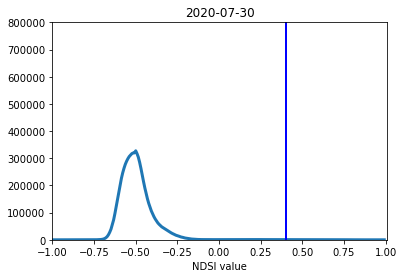

In [30]:
#for i in range(len(frames_ndsi)):
fig = plt.figure()
fig.patch.set_facecolor('white')
ax=plt.axes(xlim=(-1,1.01), ylim=(0,800000))
line,=ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    histogram, bin_edges = np.histogram(frames_ndsi.isel(time=i), bins=256, range=(-1.0, 1.0))
    line.set_data(bin_edges[0:-1], histogram)
    plt.axvline(x=0.4, color='b', label='snow presence')
    plt.title(pd.to_datetime(frames_ndsi.time.values[i]).strftime("%Y-%m-%d"))
    plt.xlabel("NDSI value")
    #plt.ylabel("Pixel count")
    return line,
    
anim=FuncAnimation(fig, animate, init_func=init,
                   frames=23, interval=0.001, blit=True)
anim.save('ndsi_hist.gif', writer='imagemagick')

In [29]:
pd.to_datetime(frames_ndsi.time.values[0]).strftime("%Y-%m-%d")
pd.to_datetime(frames_ndwi.time.values[0]).strftime("%Y-%m-%d")

'2020-04-06'

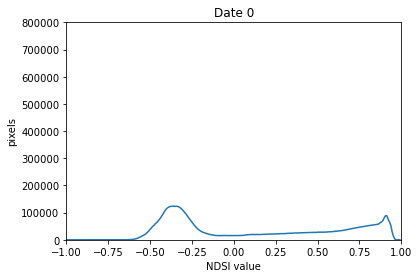

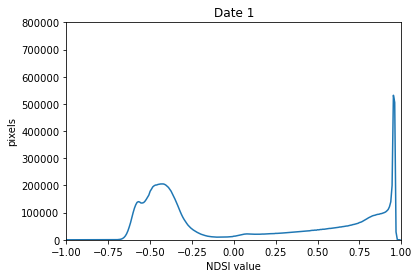

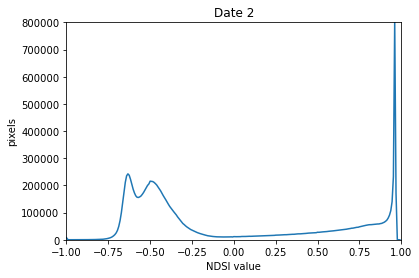

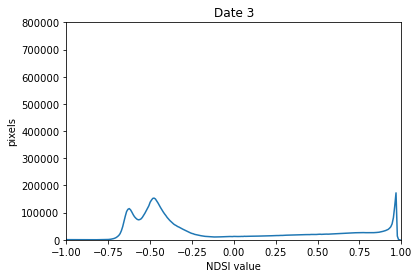

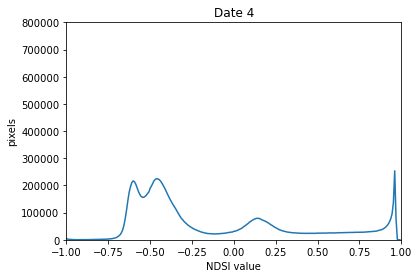

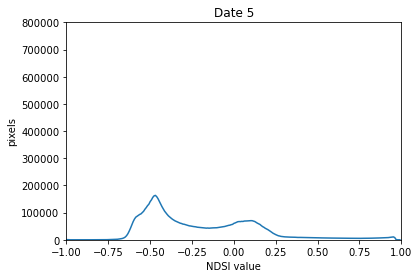

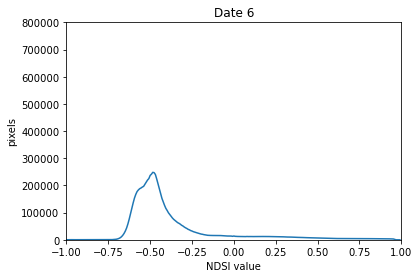

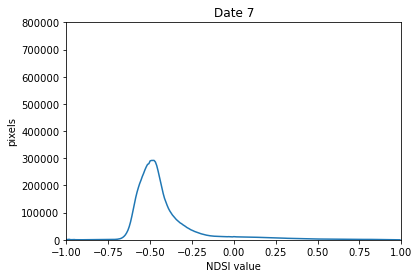

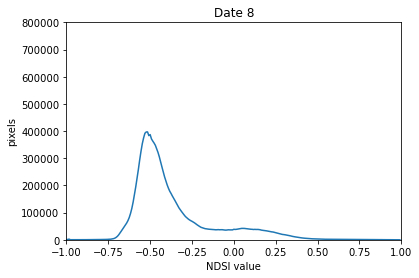

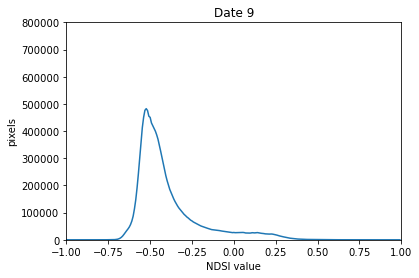

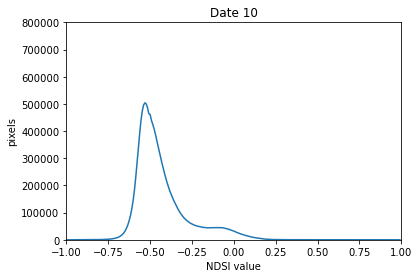

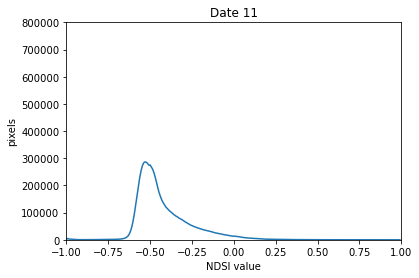

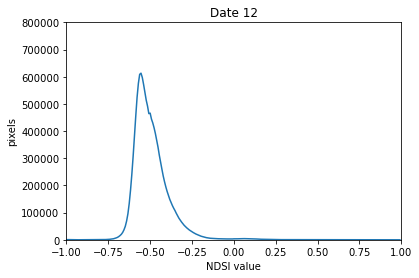

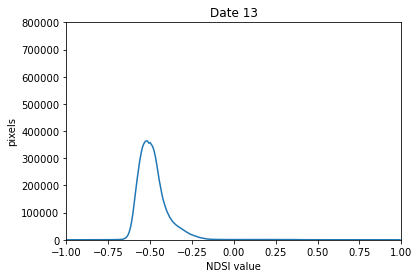

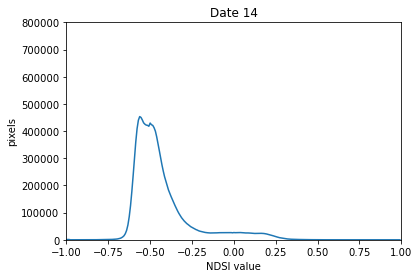

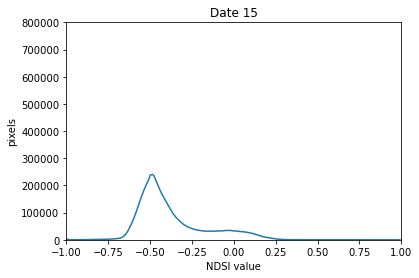

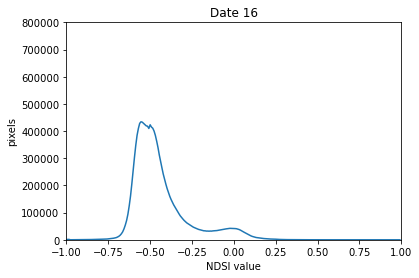

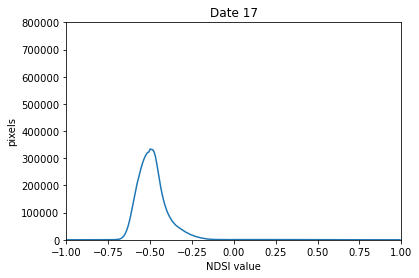

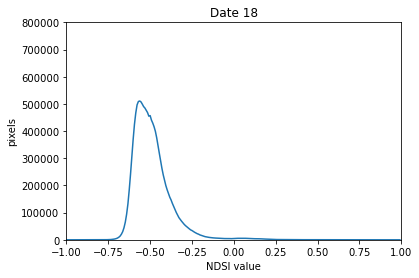

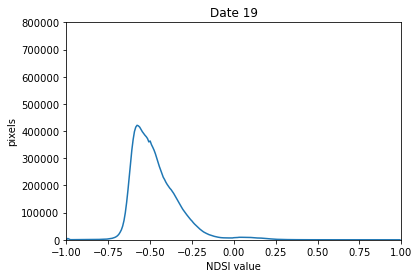

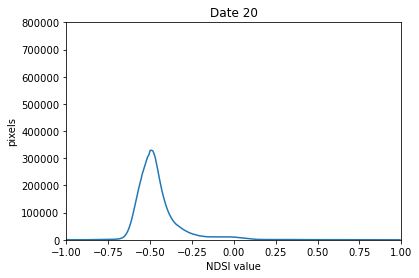

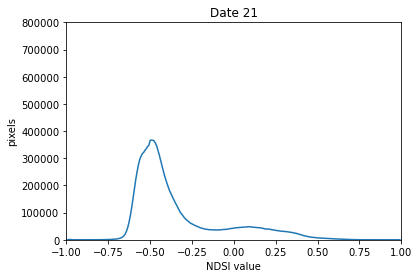

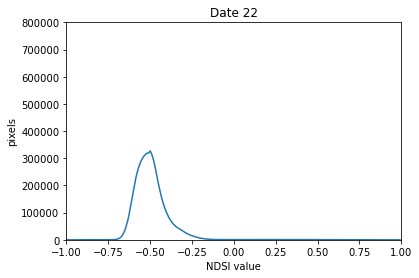

In [28]:
for i in range(len(frames_ndsi)):
    histogram, bin_edges = np.histogram(frames_ndsi.isel(time=i), bins=256, range=(-1.0, 1.0))
    fig, ax = plt.subplots()
    plt.plot(bin_edges[0:-1], histogram)
    ax.set_title('Date %d' %i)
    plt.title("NDSI Histogram")
    plt.xlabel("NDSI value")
    plt.ylabel("pixels")
    plt.xlim(-1.0, 1.0)
    plt.ylim(0,800000)
    plt.show()

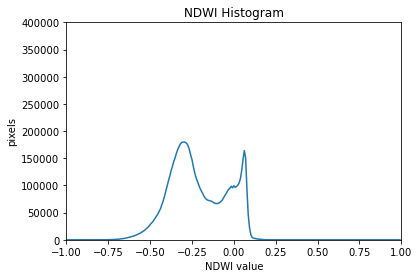

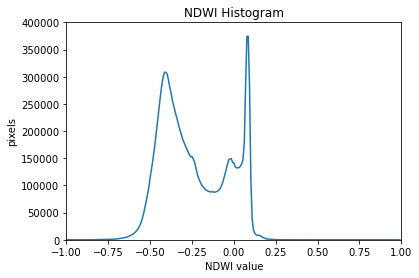

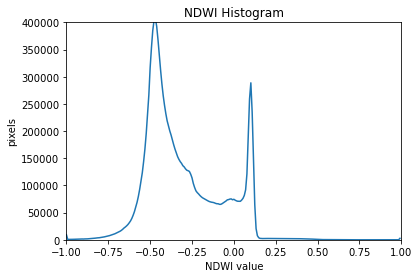

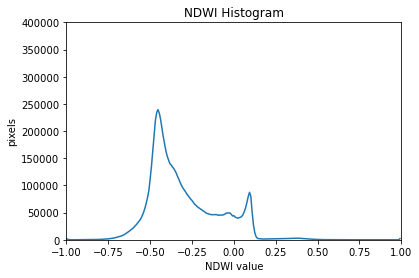

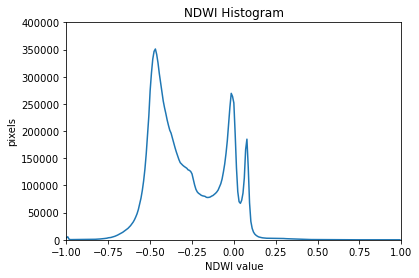

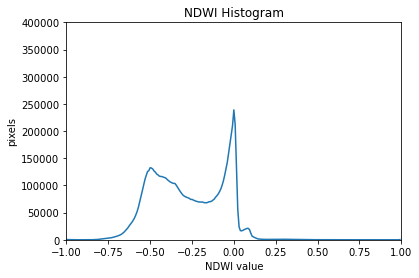

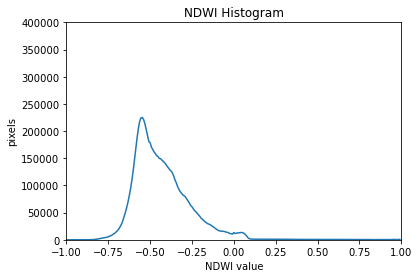

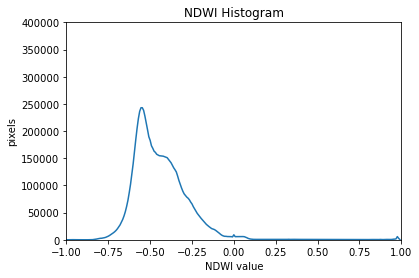

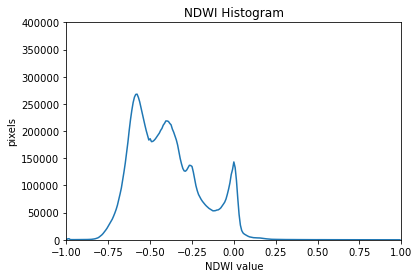

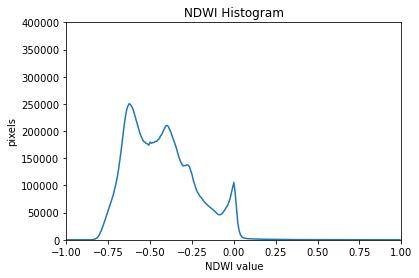

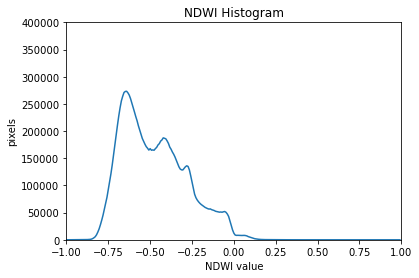

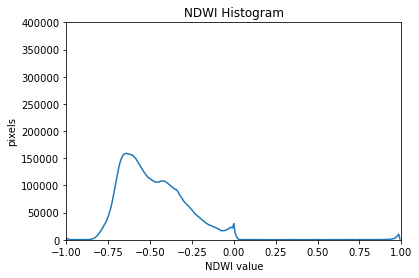

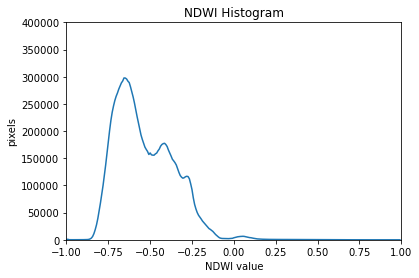

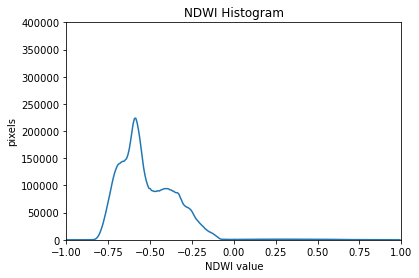

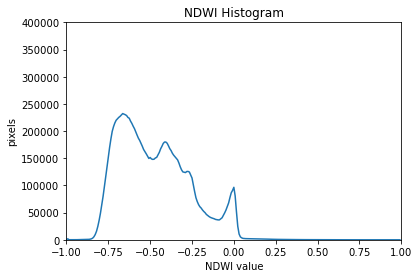

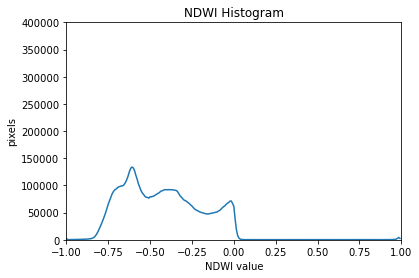

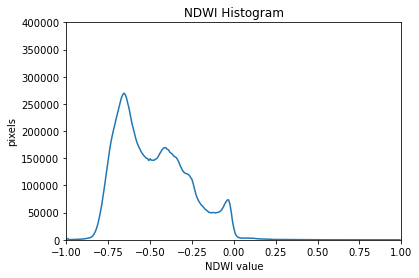

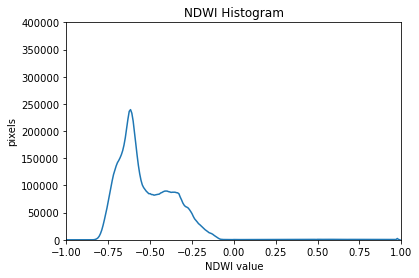

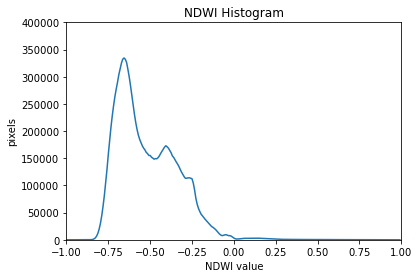

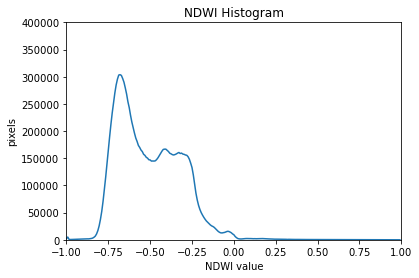

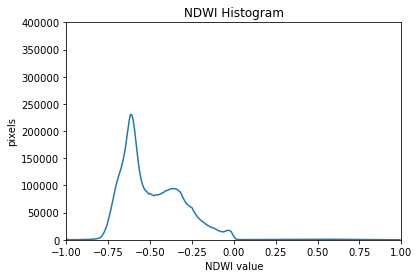

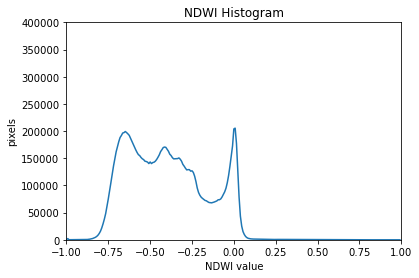

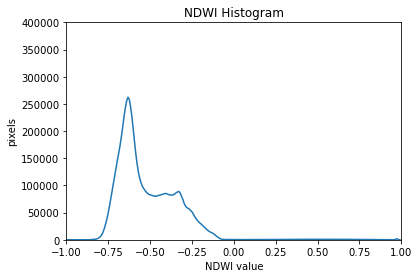

In [25]:
for i in range(len(frames_ndwi)):
    histogram, bin_edges = np.histogram(frames_ndwi.isel(time=i), bins=256, range=(-1.0, 1.0))

    fig, ax = plt.subplots()
    plt.plot(bin_edges[0:-1], histogram)
    plt.title("NDWI Histogram")
    plt.xlabel("NDWI value")
    plt.ylabel("pixels")
    plt.xlim(-1.0, 1.0)
    plt.ylim(0,400000)
    plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


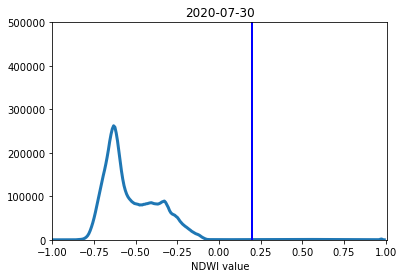

In [41]:
#for i in range(len(frames_ndsi)):
fig = plt.figure()
fig.patch.set_facecolor('white')
ax=plt.axes(xlim=(-1,1.01), ylim=(0,500000))
line,=ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    histogram, bin_edges = np.histogram(frames_ndwi.isel(time=i), bins=256, range=(-1.0, 1.0))
    line.set_data(bin_edges[0:-1], histogram)
    plt.axvline(x=0.2, color='b', label='snow presence')
    plt.title(pd.to_datetime(frames_ndwi.time.values[i]).strftime("%Y-%m-%d"))
    plt.xlabel("NDWI value")
    #plt.ylabel("Pixel count")
    return line,
    
anim=FuncAnimation(fig, animate, init_func=init,
                   frames=23, interval=0.001, blit=True)
anim.save('ndwi_hist.gif', writer='imagemagick')